In [1]:
import numpy as np                                                    # Packages for data analysis
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Circle
from scipy.ndimage import gaussian_filter1d
import braingeneers                                                   # Braingeneers code
from braingeneers.analysis.analysis import SpikeData, read_phy_files
from ipywidgets import interact, interactive, fixed, interact_manual  # package for interactive widgets 
import ipywidgets as ipw
from IPython.display import HTML, display, Javascript, clear_output
from scipy.sparse import csr_matrix
import scipy.io
from scipy.sparse import coo_matrix
import numpy as np
from decimal import Decimal, getcontext

In [2]:
sd = read_phy_files('/home/jovyan/work/Experiment/data/ephys/2023-04-02-hc328_rec/derived/kilosort2/2023_04_02_hc328_5_curated.zip')

/tmp/ipykernel_15355/4253654759.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  sd = read_phy_files('/home/jovyan/work/Experiment/data/ephys/2023-04-02-hc328_rec/derived/kilosort2/2023_04_02_hc328_5_curated.zip')


In [3]:
sd.N

72

In [4]:
sd.train

[array([2.630000e+01, 6.640000e+01, 1.007500e+02, ..., 7.001645e+04,
        7.003890e+04, 7.007840e+04]),
 array([  809.35,  1149.9 ,  1417.7 ,  1513.9 ,  1647.75,  1959.25,
         2561.3 ,  2816.5 ,  2913.15,  3043.2 ,  3166.2 ,  3572.4 ,
         3827.15,  4017.95,  4235.4 ,  4607.25,  4804.05,  5038.8 ,
         5495.9 ,  5808.85,  5987.4 ,  6079.15,  6413.1 ,  6584.55,
         6955.  ,  7329.4 ,  7666.9 ,  7772.8 ,  8483.9 ,  8615.5 ,
         9243.95,  9882.4 , 11217.15, 11540.4 , 12335.3 , 12798.35,
        13633.35, 13764.3 , 15544.95, 16110.45, 16670.85, 17061.2 ,
        17428.7 , 18195.15, 18650.  , 19218.55, 19791.6 , 21008.2 ,
        21433.5 , 22444.  , 22593.15, 22808.35, 22914.75, 23047.05,
        23231.25, 23579.2 , 23645.7 , 24166.35, 24848.75, 25024.7 ,
        25287.  , 25513.  , 25639.1 , 25909.3 , 26156.2 , 27169.75,
        27891.4 , 28346.25, 28984.7 , 29275.  , 29635.05, 30273.75,
        30737.2 , 31083.45, 31391.8 , 31747.6 , 32336.05, 32818.65,
        3

In [5]:
s_train = sd.train

In [6]:
neural_unit_index = []
spike_times = []

In [7]:
for index, array in enumerate(s_train):
    neural_unit_index.extend([index] * len(array))
    spike_times.extend(array)
    
result_array = np.column_stack((neural_unit_index, spike_times))

In [8]:
result_array[:,1] /= 1000

In [9]:
result_array[:, 0] += 1

In [10]:
result_array.shape

(9215, 2)

In [12]:
len(np.unique(result_array[:, 0]))

72

In [11]:
import scipy.io as sio
import os

In [12]:
current_directory = os.getcwd()

# Provide the file name for the .mat file
file_name = "Human_5.mat"
file_full_path = os.path.join(current_directory, file_name)

# Create a dictionary to store the numpy array with a specific variable name
data_to_save = {"spks": result_array}

# Save the dictionary to a .mat file
sio.savemat(file_full_path, data_to_save)

In [14]:
def createFCM(spksExc, spksInh=None):    
    
    # time constant of exponential profile (used for coupling)
    tau = 3e-3

    # 1e-4 binless window step in seconds
    step = 1e-4
    
    # store ids of neurons that really fired -- corresponding to entries in
    # adjacency relation
    
    if spksInh is None:
        old_ids = np.unique(spksExc[:, 0])
        spks = np.column_stack((spksExc, np.ones(len(spksExc))))
    else:
        old_ids = np.unique(np.concatenate((spksExc[:, 0], spksInh[:, 0])))
        spks = np.row_stack((np.column_stack((spksExc, np.ones(len(spksExc)))), 
                             np.column_stack((spksInh, -np.ones(len(spksInh))))))
        
    Eneuron_end = np.max(spksExc[:, 0])
    num_neurons = len(old_ids)
    
    row_indices = old_ids - 1  # Since Python uses 0-based indexing, we subtract 1 from old_ids
    col_indices = np.zeros_like(row_indices)
    values = np.arange(1, num_neurons + 1)

    new_ids = coo_matrix((values, (row_indices, col_indices)), shape=(num_neurons, 1))
    
    # frequency of spiking for individual neurons
    spike_freq = np.zeros(num_neurons)
    
    # duration of spike trains
    t_min = 0
    t_max = np.max(spksExc[:,1])
    T = t_max - t_min
    sig_length = np.ceil(T/step).astype(int)
    
    # Convert the new_ids sparse matrix to a dense NumPy array
    new_ids_array = new_ids.toarray().flatten()

    print(Eneuron_end)

    # Get spiking frequencies
    spike_freq = np.zeros(num_neurons)

    for i in range(1, num_neurons + 1):
        if i <= Eneuron_end:
            neuron_spikes = spksExc[spksExc[:, 0] == old_ids[i - 1], 1]
            spike_freq[i - 1] = np.sum(neuron_spikes) / T
        else:
            if spksInh is None:
                print("spksInh is None. Make sure it is properly defined.")
                return None
                
            neuron_spikes = spksInh[spksInh[:, 0] == old_ids[i - 1], 1]
            spike_freq[i - 1] = np.sum(neuron_spikes) / T
            
    # create signals for each neuron        
    signals = np.zeros((num_neurons, sig_length))
    for i in range(1, num_neurons + 1):
        k = old_ids[i - 1]
        IorE = np.unique(spks[spks[:, 0] == k, 2])
        # how neuron i will influence other neurons
        signals[i - 1, :] = create_signal(spks[spks[:, 0] == k, 1], step, sig_length, tau, IorE)
    
    FC_MAT = np.zeros((num_neurons, num_neurons))
    spike_vecs = np.zeros((num_neurons, sig_length))

    # Previous code up to combining with discrete spiking events...

    # Combine with discrete spiking events
    for i in range(1, num_neurons + 1):
        k = old_ids[i - 1]
        spike_times = spks[spks[:, 0] == k, 1]
        spike_times_vec = coo_matrix((np.ones_like(spike_times), 
                                      (np.ceil(spike_times / step).astype(int) - 1, 
                                       np.zeros_like(spike_times))), 
                                     shape=(sig_length, 1)).toarray().flatten()
        spike_vecs[i - 1, :] = spike_times_vec
        # Influence on neuron i from all other neurons.
        FC_MAT[:, i - 1] = signals.dot(spike_times_vec)

    # Thresholding
    FC_MAT[FC_MAT < 0] = 0
    FC_MAT = FC_MAT - np.diag(np.diag(FC_MAT))

    # Frequency normalization
    freq_normalization = spike_freq / np.maximum(spike_freq, 1)  # Divide element-wise with maximum value of 1
    freq_normalization[freq_normalization > 1] = 1

    FC_MAT = FC_MAT * freq_normalization

    return FC_MAT

In [15]:
def create_signal(start_times, dt, sig_length, tau, mode):
    # time vector
    t_vec = np.arange(dt, (sig_length + 1) * dt, dt)

    q = np.zeros_like(t_vec)

    if mode == 1:
        for k in range(len(start_times)):
            qq = np.exp(-(t_vec - start_times[k]) / tau)
            qq[qq > 1] = 0
            if k < len(start_times) - 1:
                qq[t_vec >= start_times[k + 1]] = 0
            q = q + qq
    else:
        for k in range(len(start_times)):
            qq = np.exp(-(t_vec - start_times[k]) / tau)
            qq[qq > 1] = 0
            qq = 1 - qq
            qq[qq > 0.99] = 0  # corresponds to ~4.5 tau
            if k < len(start_times) - 1:
                qq[t_vec >= start_times[k + 1]] = 0
            q = q + qq

    # due to rounding of spiking times, the exponential may sometimes not start at 1
    if mode == 1:
        idx = np.ceil(start_times / dt).astype(int) - 1
        idx = np.clip(idx, 0, len(q) - 1)  # Clip indices to be within valid range
        q[idx] = 1

    # shift to zero mean and make magnitude normalized
    q = q - np.mean(q)
    q = q / (np.max(q) * len(start_times))

    return q

In [16]:
FC_MAT = createFCM(result_array)

72.0


/tmp/ipykernel_1390011/3072996499.py:9: RuntimeWarning: overflow encountered in exp
  qq = np.exp(-(t_vec - start_times[k]) / tau)


In [17]:
FC_MAT

array([[0.        , 0.        , 0.00276831, ..., 0.        , 0.        ,
        0.00045705],
       [0.00490294, 0.        , 0.00100146, ..., 0.        , 0.0058181 ,
        0.        ],
       [0.0300288 , 0.        , 0.        , ..., 0.00051975, 0.01027648,
        0.00036457],
       ...,
       [0.        , 0.01883247, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00206113, 0.        , 0.        , ..., 0.00118709, 0.        ,
        0.        ],
       [0.00068901, 0.        , 0.00480187, ..., 0.        , 0.00911224,
        0.        ]])

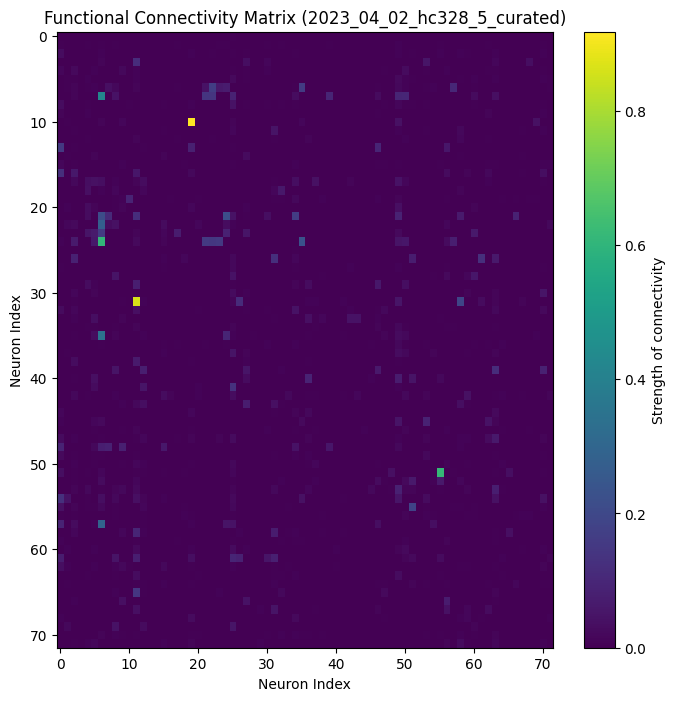

In [22]:
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
heatmap = plt.imshow(FC_MAT, cmap='viridis', aspect='auto')
colorbar = plt.colorbar(heatmap)  # Add a colorbar for better interpretation
colorbar.set_label('Strength of connectivity')  # Add the label to the colorbar
plt.title('Functional Connectivity Matrix (2023_04_02_hc328_5_curated)')
plt.xlabel('Neuron Index')
plt.ylabel('Neuron Index')
plt.show()

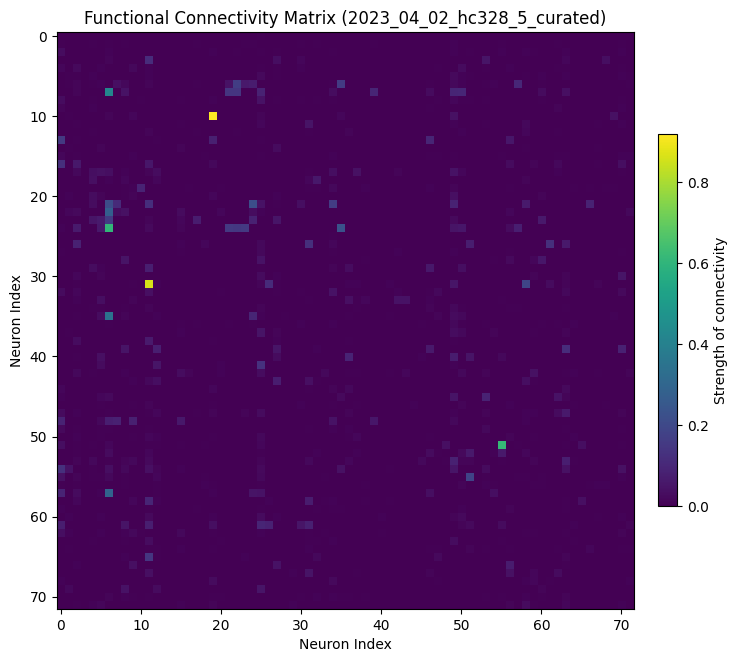

In [25]:
# Create a square figure with a shorter colorbar
fig, ax = plt.subplots(figsize=(8, 8))
heatmap = ax.imshow(FC_MAT, cmap='viridis', aspect='equal')

# Add a colorbar for better interpretation
colorbar = plt.colorbar(heatmap, fraction=0.03, pad=0.04)  # Adjust fraction and pad as needed
colorbar.set_label('Strength of connectivity')  # Add the label to the colorbar

# Adjust the layout and titles
plt.title('Functional Connectivity Matrix (2023_04_02_hc328_5_curated)')
plt.xlabel('Neuron Index')
plt.ylabel('Neuron Index')

plt.show()

In [26]:
def correlation(sd):
    # Correlation
    corr = np.zeros((sd.N,sd.N)) #inds by inds

    dense_raster = sd.raster(bin_size=1) # in ms
    sigma = 5                            # Blur it
    dense_raster = gaussian_filter1d(dense_raster.astype(float),sigma=sigma) 
    corr=np.corrcoef( dense_raster )
    
    plt.imshow(corr)
    plt.title('Correlation Matrix (2023_04_02_hc328_5_curated)')
    plt.xlabel("Neuron index")
    plt.ylabel("Neuron index")
    plt.show()

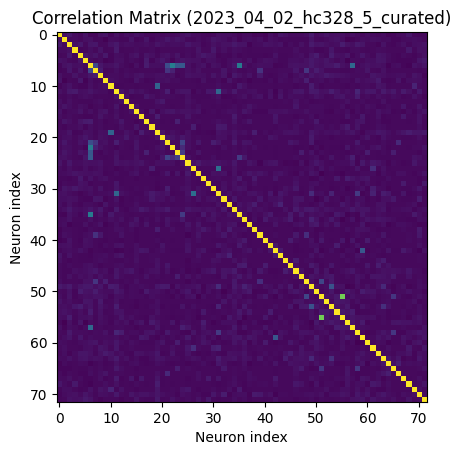

In [27]:
correlation(sd)

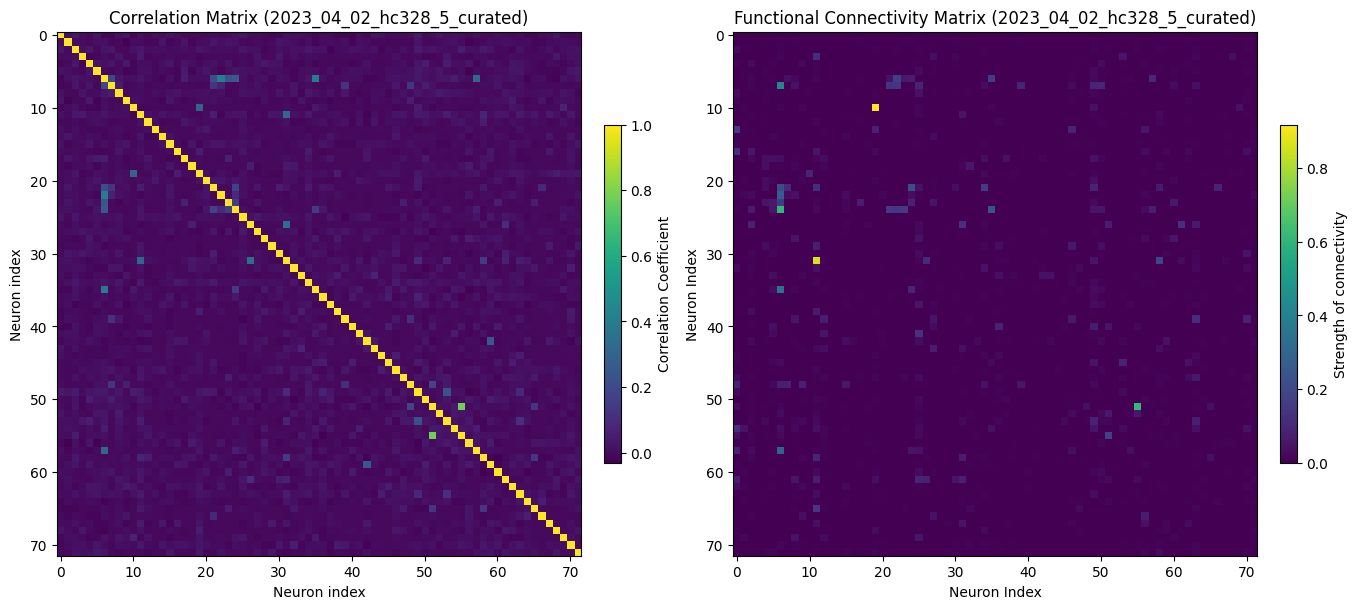

In [30]:
def correlation(sd):
    # Correlation
    corr = np.zeros((sd.N,sd.N)) #inds by inds

    dense_raster = sd.raster(bin_size=1) # in ms
    sigma = 5                            # Blur it
    dense_raster = gaussian_filter1d(dense_raster.astype(float),sigma=sigma) 
    corr = np.corrcoef(dense_raster)
    return corr

# Assume you have already defined sd and FC_MAT

# Get the correlation matrix from the first code
corr_matrix = correlation(sd)

# Create a square figure with a shorter colorbar
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot the correlation matrix on the first subplot
heatmap1 = axs[0].imshow(corr_matrix)
axs[0].set_title('Correlation Matrix (2023_04_02_hc328_5_curated)')
axs[0].set_xlabel("Neuron index")
axs[0].set_ylabel("Neuron index")

# Plot the functional connectivity matrix on the second subplot
heatmap2 = axs[1].imshow(FC_MAT, cmap='viridis', aspect='equal')
axs[1].set_title('Functional Connectivity Matrix (2023_04_02_hc328_5_curated)')
axs[1].set_xlabel('Neuron Index')
axs[1].set_ylabel('Neuron Index')

# Add colorbars for better interpretation
colorbar1 = plt.colorbar(heatmap1, ax=axs[0], fraction=0.03, pad=0.04)
colorbar1.set_label('Correlation Coefficient')

colorbar2 = plt.colorbar(heatmap2, ax=axs[1], fraction=0.03, pad=0.04)
colorbar2.set_label('Strength of connectivity')

plt.savefig('correlation_fcm_plot.png')

plt.show()

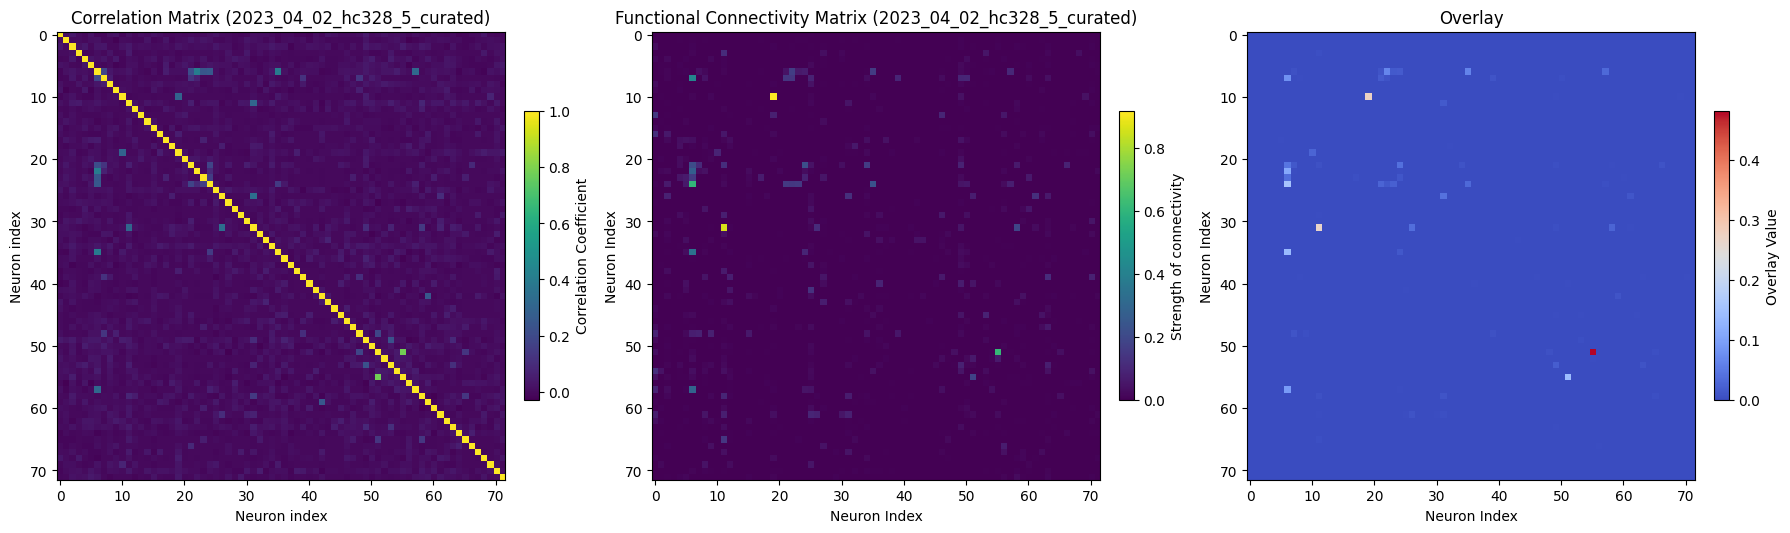

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def correlation(sd):
    # Correlation
    corr = np.zeros((sd.N, sd.N)) #inds by inds

    dense_raster = sd.raster(bin_size=1) # in ms
    sigma = 5                            # Blur it
    dense_raster = gaussian_filter1d(dense_raster.astype(float), sigma=sigma) 
    corr = np.corrcoef(dense_raster)
    return corr

# Assume you have already defined sd and FC_MAT

# Get the correlation matrix from the first code
corr_matrix = correlation(sd)

# Create a 2x2 subplot arrangement
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot the correlation matrix on the first subplot
heatmap1 = axs[0].imshow(corr_matrix, cmap='viridis')
axs[0].set_title('Correlation Matrix (2023_04_02_hc328_5_curated)')
axs[0].set_xlabel("Neuron index")
axs[0].set_ylabel("Neuron index")

# Plot the functional connectivity matrix on the second subplot
heatmap2 = axs[1].imshow(FC_MAT, cmap='viridis', aspect='equal')
axs[1].set_title('Functional Connectivity Matrix (2023_04_02_hc328_5_curated)')
axs[1].set_xlabel('Neuron Index')
axs[1].set_ylabel('Neuron Index')

# Overlay the correlation and functional connectivity matrices on the third subplot
overlay = corr_matrix * FC_MAT
overlay_min = np.min(overlay)
overlay_max = np.max(overlay)
heatmap3 = axs[2].imshow(overlay, cmap='coolwarm', aspect='equal', vmin=overlay_min, vmax=overlay_max)
axs[2].set_title('Overlay')
axs[2].set_xlabel('Neuron Index')
axs[2].set_ylabel('Neuron Index')

# Add colorbars for better interpretation
colorbar1 = plt.colorbar(heatmap1, ax=axs[0], fraction=0.03, pad=0.04)
colorbar1.set_label('Correlation Coefficient')

colorbar2 = plt.colorbar(heatmap2, ax=axs[1], fraction=0.03, pad=0.04)
colorbar2.set_label('Strength of connectivity')

colorbar3 = plt.colorbar(heatmap3, ax=axs[2], fraction=0.03, pad=0.04)
colorbar3.set_label('Overlay Value')

plt.tight_layout()

plt.savefig('correlation_fcm_overlay_plot.png')


plt.show()

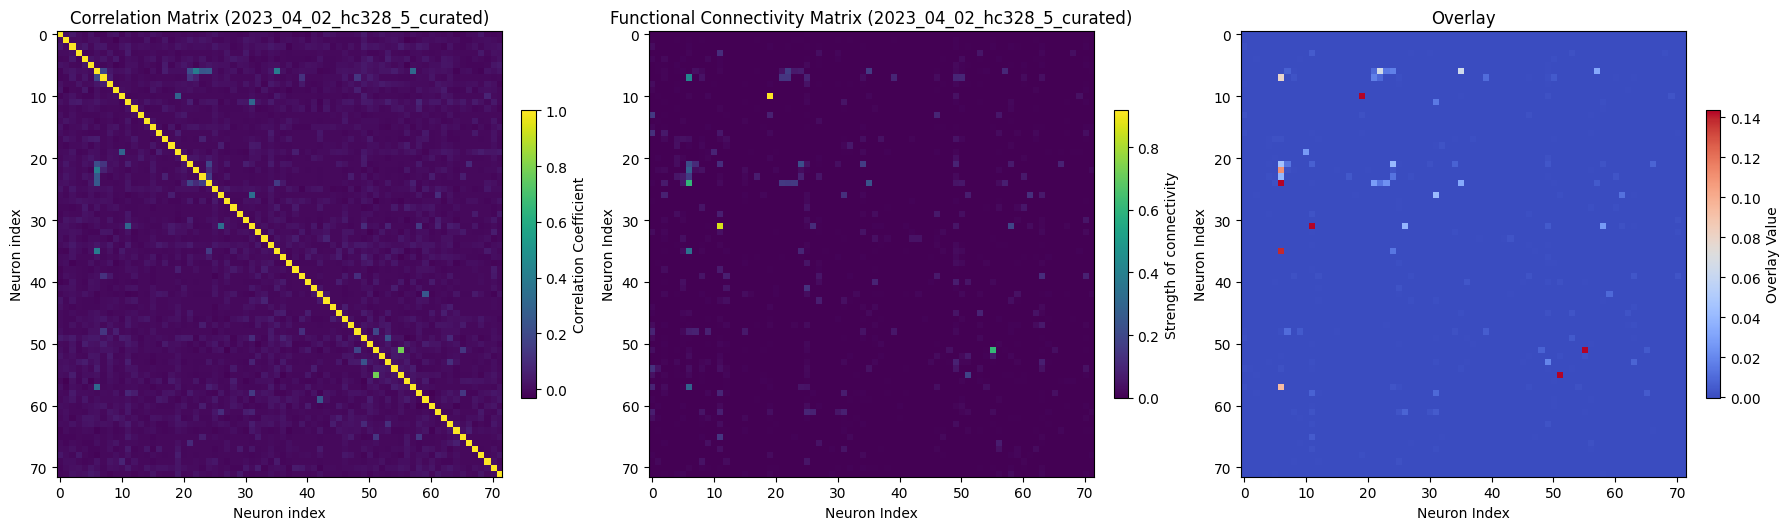

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def correlation(sd):
    # Correlation
    corr = np.zeros((sd.N, sd.N)) #inds by inds

    dense_raster = sd.raster(bin_size=1) # in ms
    sigma = 5                            # Blur it
    dense_raster = gaussian_filter1d(dense_raster.astype(float), sigma=sigma) 
    corr = np.corrcoef(dense_raster)
    return corr

# Assume you have already defined sd and FC_MAT

# Get the correlation matrix from the first code
corr_matrix = correlation(sd)

# Create a 2x2 subplot arrangement
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot the correlation matrix on the first subplot
heatmap1 = axs[0].imshow(corr_matrix, cmap='viridis')
axs[0].set_title('Correlation Matrix (2023_04_02_hc328_5_curated)')
axs[0].set_xlabel("Neuron index")
axs[0].set_ylabel("Neuron index")

# Plot the functional connectivity matrix on the second subplot
heatmap2 = axs[1].imshow(FC_MAT, cmap='viridis', aspect='equal')
axs[1].set_title('Functional Connectivity Matrix (2023_04_02_hc328_5_curated)')
axs[1].set_xlabel('Neuron Index')
axs[1].set_ylabel('Neuron Index')

# Overlay the correlation and functional connectivity matrices on the third subplot
overlay = corr_matrix * FC_MAT
overlay_min = np.min(overlay)
overlay_max = np.percentile(overlay, 99.92)  # Adjust percentile as needed
heatmap3 = axs[2].imshow(overlay, cmap='coolwarm', aspect='equal', vmin=overlay_min, vmax=overlay_max)
axs[2].set_title('Overlay')
axs[2].set_xlabel('Neuron Index')
axs[2].set_ylabel('Neuron Index')

# Add colorbars for better interpretation
colorbar1 = plt.colorbar(heatmap1, ax=axs[0], fraction=0.03, pad=0.04)
colorbar1.set_label('Correlation Coefficient')

colorbar2 = plt.colorbar(heatmap2, ax=axs[1], fraction=0.03, pad=0.04)
colorbar2.set_label('Strength of connectivity')

colorbar3 = plt.colorbar(heatmap3, ax=axs[2], fraction=0.03, pad=0.04)
colorbar3.set_label('Overlay Value')

plt.tight_layout()

plt.savefig('correlation_fcm_overlay_plot_scaled.png')

plt.show()

In [1]:
!jt -r

Reset css and font defaults in:
/home/jovyan/.jupyter/custom &
/home/jovyan/.local/share/jupyter/nbextensions
